# #WaveSight

In [2]:
%load_ext autoreload
%autoreload 2
# assuming there's a file scripto.py in the same folder as the ipynb
import wavesight as ws
import sympy as sp
import numpy as np
from scipy import special
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from scipy.optimize import fsolve, root_scalar
import cmasher as cm
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
%config InlineBackend.figure_format='retina'
import warnings
print("Warning disabling RuntimeWarning often due to evalution of square roots with negative arguments.\nProbably produced by scalar_root.")
warnings.filterwarnings("ignore", category=RuntimeWarning)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Warning disabling RuntimeWarning often due to evalution of square roots with negative arguments.
Probably produced by scalar_root.


## ##Jackson Notation

/Users/juan/ZiaLab/Codebase/wavesight/wavesight.py:43: RuntimeWarning: invalid value encountered in sqrt
  return  (n1**2*(special.jv(-1 + n,a*np.sqrt(-γ**2 + (4*n1**2*np.pi**2)/λfree**2)) - special.jv(1 + n,a*np.sqrt(-γ**2 + (4*n1**2*np.pi**2)/λfree**2))))/(2.*a*n0**2*np.sqrt(-γ**2 + (4*n1**2*np.pi**2)/λfree**2)*special.jv(n,a*np.sqrt(-γ**2 + (4*n1**2*np.pi**2)/λfree**2))) + (-special.kn(-1 + n,a*np.sqrt(γ**2 - (4*n0**2*np.pi**2)/λfree**2)) - special.kn(1 + n,a*np.sqrt(γ**2 - (4*n0**2*np.pi**2)/λfree**2)))/(2.*a*np.sqrt(γ**2 - (4*n0**2*np.pi**2)/λfree**2)*special.kn(n,a*np.sqrt(γ**2 - (4*n0**2*np.pi**2)/λfree**2)))


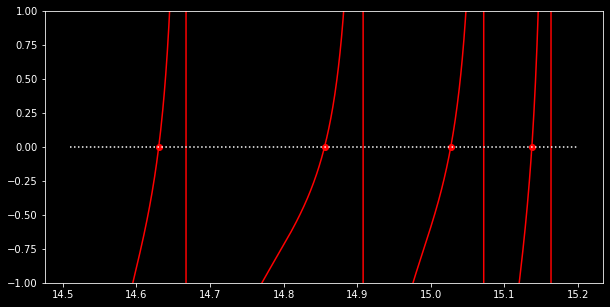

In [756]:
nCore = 1.45
nCladding = 1.387
coreRadius = 3.
wavelength = 0.6
tmfun = ws.tmfungen(λfree=wavelength, 
                 n2=nCladding, 
                 n1=nCore, 
                 a=coreRadius)
kzmax = 1.001*nCore*2*np.pi/wavelength
kzmin = 0.999*nCladding*2*np.pi/wavelength
kzrange = np.linspace(kzmin, kzmax, 1000)
tmvals = tmfun(kzrange)
tmzeros = ws.findallroots(tmfun, kzmin, kzmax, 0.01, method='bisect', num_sigfigs=6, verbose=False)
tmzerocheck = tmfun(tmzeros)
plt.figure(figsize=(10,5))
plt.plot(kzrange, tmvals, 'r')
plt.scatter(tmzeros,tmzerocheck, c='r')
plt.plot([kzmin, kzmax], [0,0], "w:")
plt.ylim(-1,1)
plt.show()

## ##The Fields

Solve the propagation constants of a fiber of the given geometry 
and plot the axial field together with density plots for the tangential
field.

Calculate a numerical basis using the calculated modes.

In [4]:
fiber_spec = {'NA': 0.39,
              'nCore': 1.45,
              'coreRadius':3.,
              'free_space_wavelength': 0.600}
fiber_sol = ws.multisolver(fiber_spec, drawPlots=False, verbose=True)

Approx number of complex HE modes:  31
Approx number of TE modes:  6
Approx number of TM modes:  6
Approx number of total modes:  75
Approx Max n for HE modes:  7
Calculting TE(0,n) propagation constants ...
Calculting TM(0,n) propagation constants ...
Calculting HE(m,n) propagation constants ...
m=10
HE modes = 68
TE modes = 8
TM modes = 8
TOTAL modes = 84
FROM_Vnum = 75


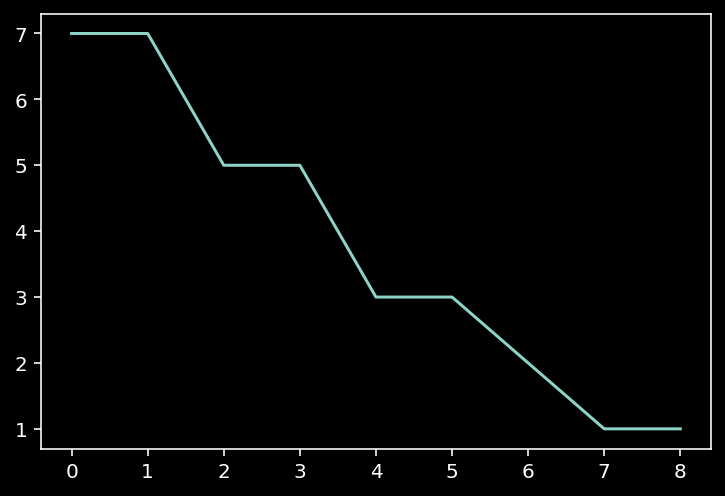

In [5]:
TEcounter = list(map(len,fiber_sol['HEkz'].values()))
plt.figure()
plt.plot(TEcounter)
plt.show()

### ###HE modes

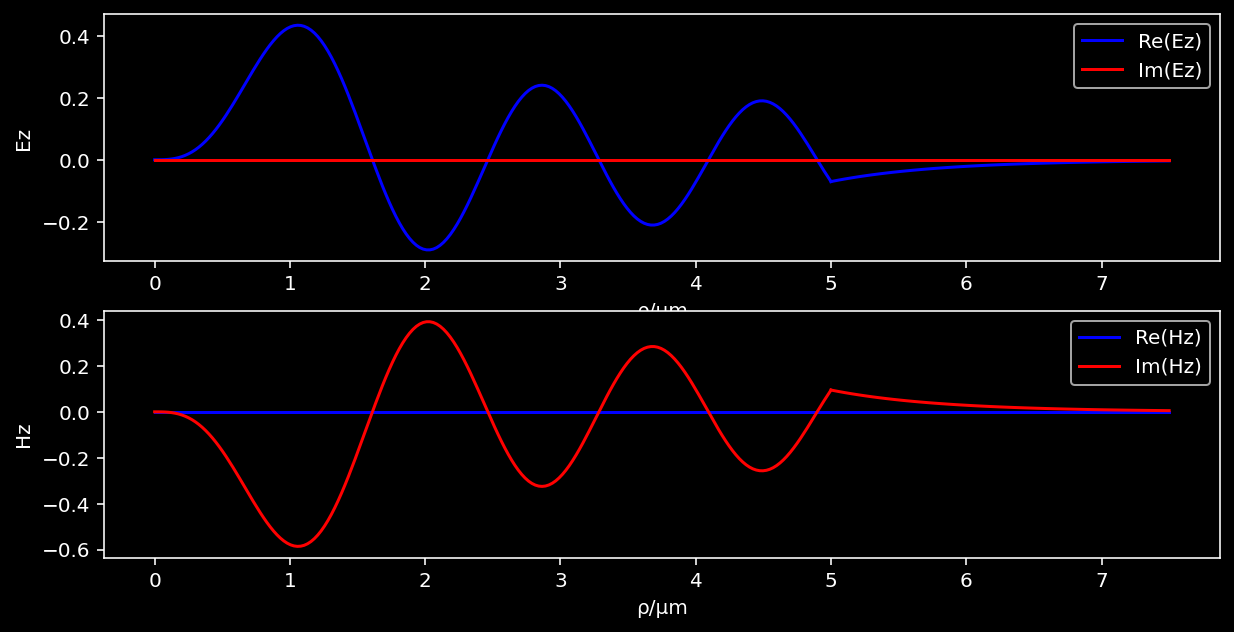

In [43]:
a = fiber_sol['coreRadius']
b = a*1.5 # assumed, in reality the cladding is assumed to be infinite
nCore = fiber_sol['nCore']
nCladding = fiber_sol['nCladding']

# given a value for m, plot the axial and transverse fields
m = 3
kz = fiber_sol['HEkz'][m][0]
λfree = fiber_sol['free_space_wavelength']
γ = np.sqrt(nCore**2*4*np.pi**2/λfree**2 - kz**2)
β = np.sqrt(kz**2 - nCladding**2*4*np.pi**2/λfree**2)

Ae, Ah, Be, Bh = ws.AeAhBeBh("HE", a, nCore, nCladding, λfree, m, kz)

Ez_1 = ws.Ezgen_1(Ae, m, γ)
Ez_2 = ws.Ezgen_2(Be, m, β)
Hz_1 = ws.Hzgen_1(Ah, m, γ)
Hz_2 = ws.Hzgen_2(Bh, m, β)

Et1 = ws.Et1gen_1(Ae, Ah, Be, Bh, m, β, γ, kz, λfree)
Et2 = ws.Et2gen_1(Ae, Ah, Be, Bh, m, β, γ, kz, λfree)
Ht1 = ws.Ht1gen_1(Ae, Ah, Be, Bh, m, β, γ, kz, λfree, nCore)
Ht2 = ws.Ht2gen_1(Ae, Ah, Be, Bh, m, β, γ, kz, λfree, nCladding)

ρrangein = np.linspace(0, a, 200)
ρrangeout = np.linspace(a, b, 50)

Ezvals1 = Ez_1(ρrangein)
Ezvals2 = Ez_2(ρrangeout)
Hzvals1 = Hz_1(ρrangein)
Hzvals2 = Hz_2(ρrangeout)

fig, ax = plt.subplots(nrows=2,figsize=(10,5))
ax[0].plot(ρrangein, np.real(Ezvals1), 'b', label='Re(Ez)')
ax[0].plot(ρrangeout, np.real(Ezvals2), 'b')
ax[0].plot(ρrangein, np.imag(Ezvals1), 'r', label='Im(Ez)')
ax[0].plot(ρrangeout, np.imag(Ezvals2), 'r')
ax[0].set_xlabel('ρ/µm')
ax[0].set_ylabel('Ez')
ax[0].legend()
ax[1].plot(ρrangein, np.real(Hzvals1),'b', label='Re(Hz)')
ax[1].plot(ρrangeout, np.real(Hzvals2),'b')
ax[1].plot(ρrangein, np.imag(Hzvals1),'r', label='Im(Hz)')
ax[1].plot(ρrangeout, np.imag(Hzvals2),'r')
ax[1].set_xlabel('ρ/µm')
ax[1].set_ylabel('Hz')
ax[1].legend()
plt.subplots_adjust()
plt.show()

In [44]:
xrange = np.linspace(-b, b, 200)
yrange = np.linspace(-b, b, 200)
X, Y = np.meshgrid(xrange, yrange)
Etvals1 = Et1(X, Y)
Etvals2 = Et2(X, Y)
Htvals1 = Ht1(X, Y)
Htvals2 = Ht2(X, Y)

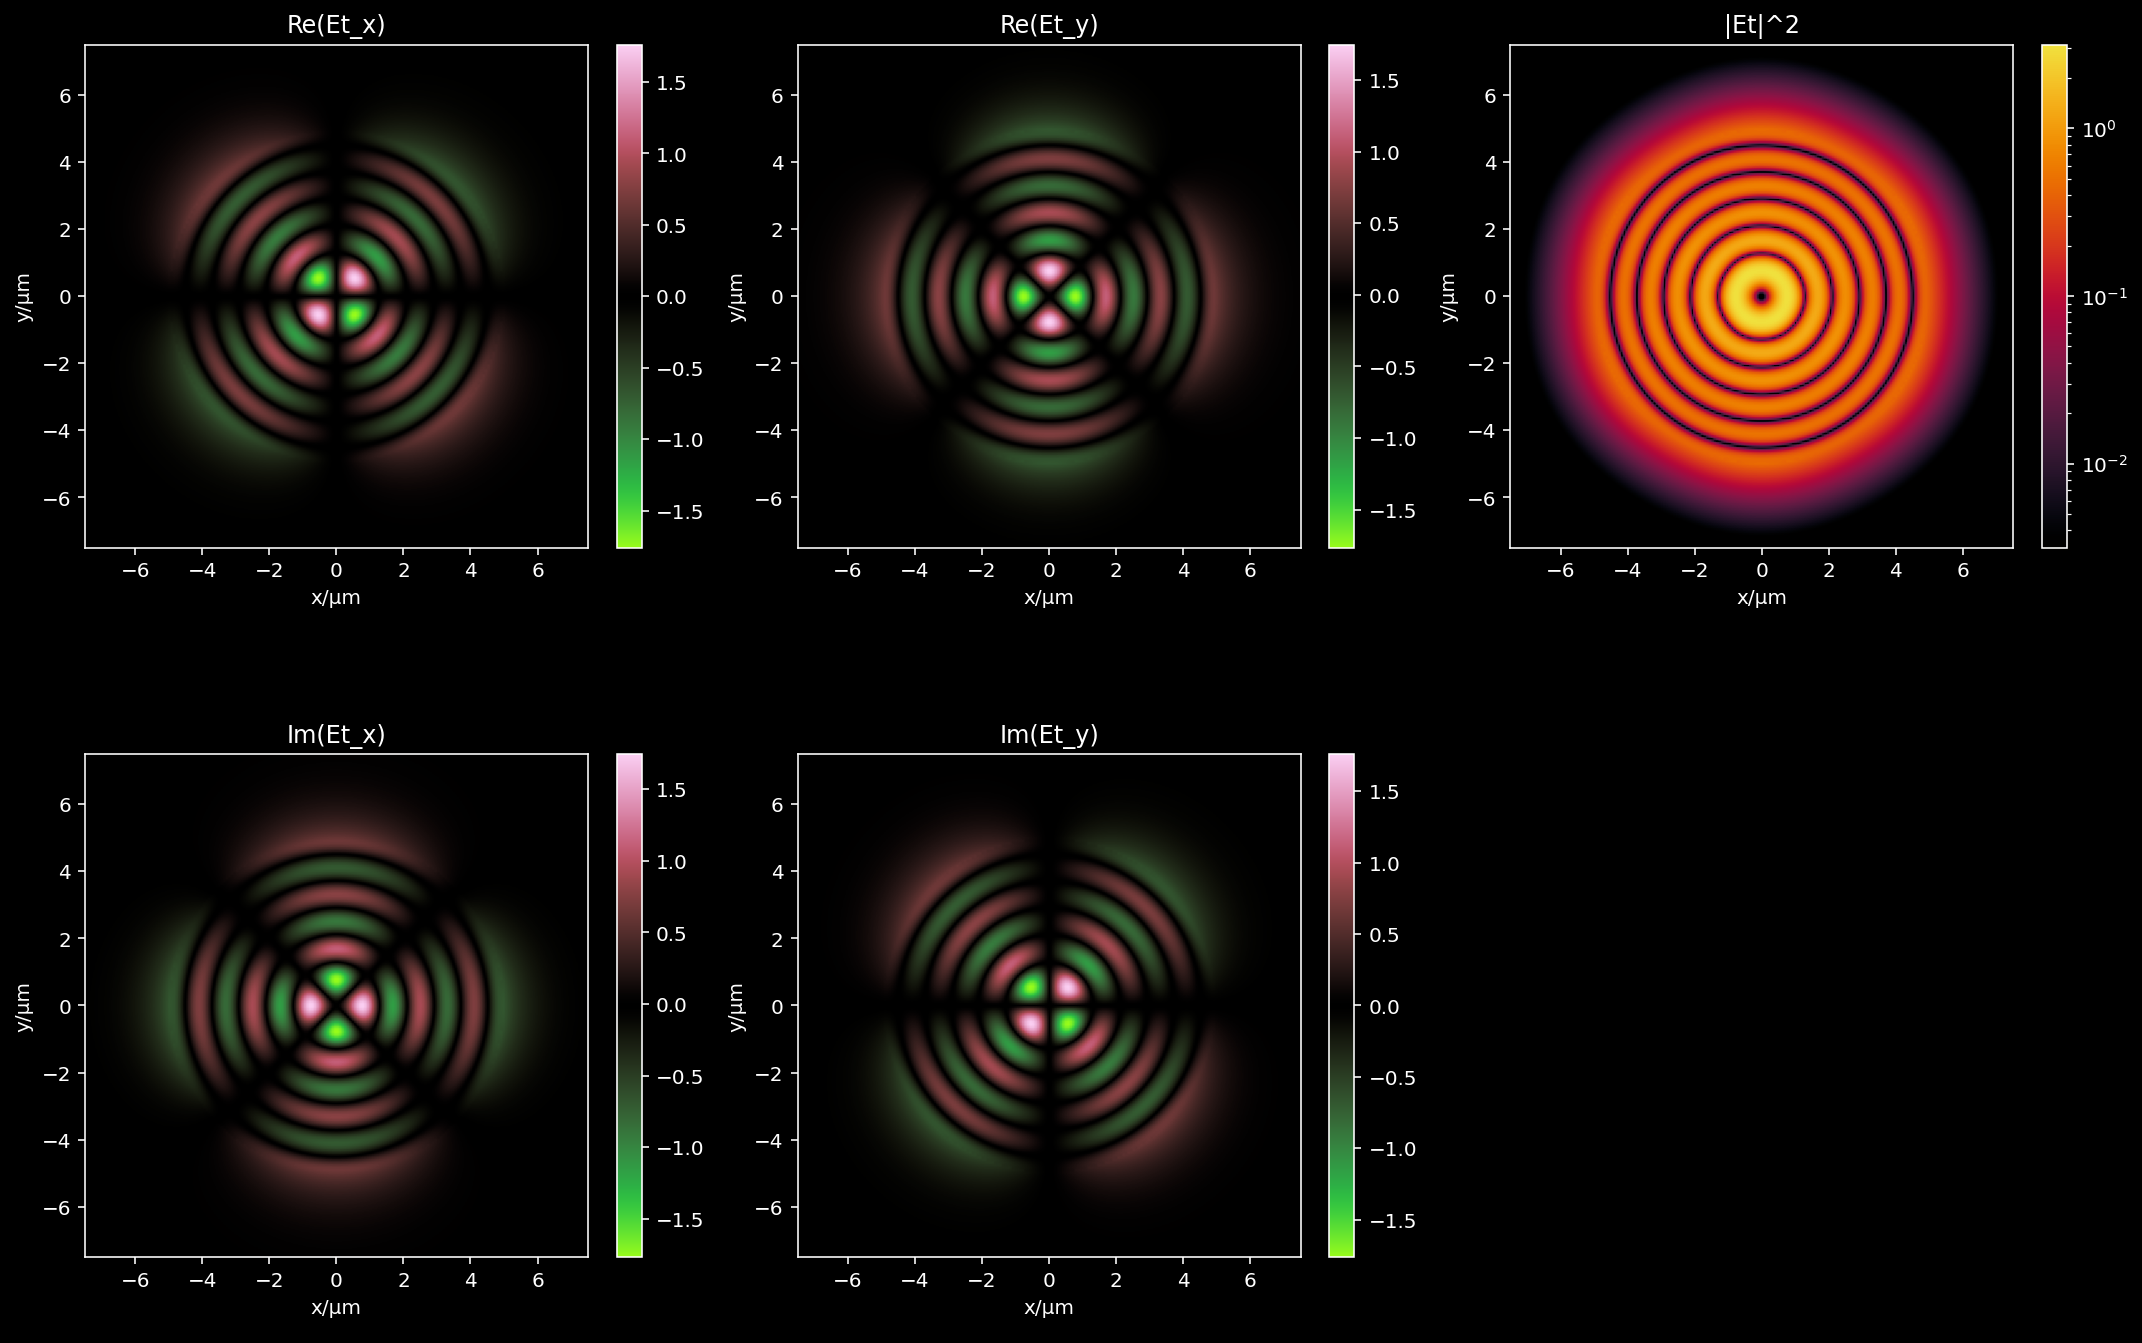

In [45]:
fieldarray1 = np.real(Etvals1[0,:,])
fieldarray1[X**2 + Y**2 > a**2] = 0
fieldarray2 = np.real(Etvals2[0,:,])
fieldarray2[X**2 + Y**2 < a**2] = 0
fieldarray_x = fieldarray1 + fieldarray2

fieldarray1 = np.real(Etvals1[1,:,])
fieldarray1[X**2 + Y**2 > a**2] = 0
fieldarray2 = np.real(Etvals2[1,:,])
fieldarray2[X**2 + Y**2 < a**2] = 0
fieldarray_y = fieldarray1 + fieldarray2

fieldarray1 = np.real(Etvals1[0,:,])**2 + np.real(Etvals1[1,:,])**2
fieldarray1[X**2 + Y**2 > a**2] = 0
fieldarray2 = np.real(Etvals2[0,:,])**2 + np.real(Etvals2[1,:,])**2
fieldarray2[X**2 + Y**2 < a**2] = 0
fieldarray_mag2 = fieldarray1 + fieldarray2

fieldarray1 = np.imag(Etvals1[0,:,])
fieldarray1[X**2 + Y**2 > a**2] = 0
fieldarray2 = np.imag(Etvals2[0,:,])
fieldarray2[X**2 + Y**2 < a**2] = 0
fieldarray_xim = fieldarray1 + fieldarray2

fieldarray1 = np.imag(Etvals1[1,:,])
fieldarray1[X**2 + Y**2 > a**2] = 0
fieldarray2 = np.imag(Etvals2[1,:,])
fieldarray2[X**2 + Y**2 < a**2] = 0
fieldarray_yim = fieldarray1 + fieldarray2

plotfields = [fieldarray_x, fieldarray_y, fieldarray_mag2, fieldarray_xim, fieldarray_yim]

labels = ['Re(Et_x)', 'Re(Et_y)', '|Et|^2', 'Im(Et_x)', 'Im(Et_y)']

fig, axes = plt.subplots(nrows = 2, ncols=3, figsize=(15,10))

for idx, (pfield, label) in enumerate(zip(plotfields, labels)):
    ax = axes[idx//3, idx%3]
    if label == '|Et|^2':
        cmap = cm.ember
        maxmag2 = np.max(fieldarray_mag2)
        iplot = ax.imshow(fieldarray_mag2, 
                norm=LogNorm(vmin=maxmag2*1e-3, vmax=maxmag2),
                cmap=cmap, 
                extent=[-a*1.5, a*1.5, -a*1.5, a*1.5])
    else:
        cmap = cm.watermelon
        iplot = ax.imshow(pfield, 
            cmap=cmap, 
            extent=[-a*1.5, a*1.5, -a*1.5, a*1.5])
    ax.set_title(label)
    ax.set_xlabel('x/µm')
    ax.set_ylabel('y/µm')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.2)
    plt.colorbar(iplot, cax=cax)

axes[1,2].set_axis_off()

plt.tight_layout()
plt.show()

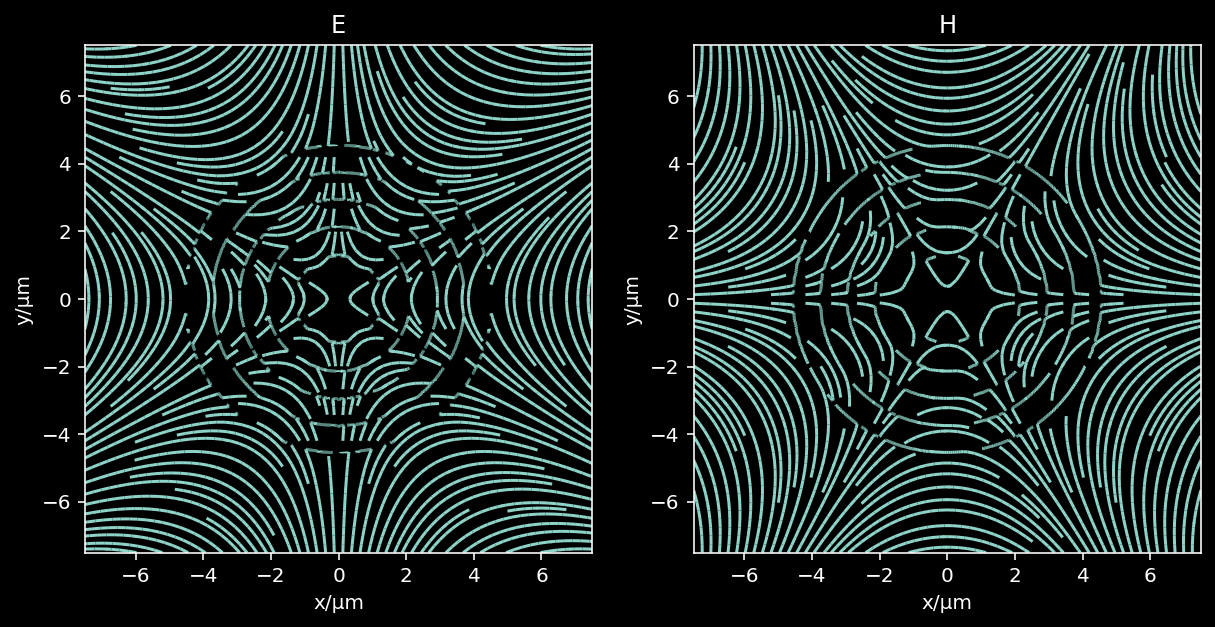

In [46]:
Ex1 = np.real(Etvals1[0,:,:])
Ex1[X**2 + Y**2 > a**2] = 0
Ex2 = np.real(Etvals2[0,:,:])
Ex2[X**2 + Y**2 < a**2] = 0
Ex = Ex1 + Ex2
Ey1 = np.real(Etvals1[1,:,:])
Ey1[X**2 + Y**2 > a**2] = 0
Ey2 = np.real(Etvals2[1,:,:])
Ey2[X**2 + Y**2 < a**2] = 0
Ey = Ey1 + Ey2

Hx1 = np.real(Htvals1[0,:,:])
Hx1[X**2 + Y**2 > a**2] = 0
Hx2 = np.real(Htvals2[0,:,:])
Hx2[X**2 + Y**2 < a**2] = 0
Hx = Hx1 + Hx2
Hy1 = np.real(Htvals1[1,:,:])
Hy1[X**2 + Y**2 > a**2] = 0
Hy2 = np.real(Htvals2[1,:,:])
Hy2[X**2 + Y**2 < a**2] = 0
Hy = Hy1 + Hy2

fig, axes = plt.subplots(ncols=2, figsize=(10,5))
axes[0].streamplot(xrange, yrange, Ex, Ey, arrowstyle='-', density=2)
axes[0].set_xlabel('x/µm')
axes[0].set_ylabel('y/µm')
axes[0].set_title('E')
axes[0].set_aspect('equal')

axes[1].streamplot(xrange, yrange, Hx, Hy, arrowstyle='-', density=2)
axes[1].set_xlabel('x/µm')
axes[1].set_ylabel('y/µm')
axes[1].set_title('H')
axes[1].set_aspect('equal')
plt.show()

### ###TM and TE modes

In [8]:
# def AeTE(a, n1, n2, λfree, kz):
#     return 1

# def AhTE(a, n1, n2, λfree, kz):
#     return 0

# def BeTE(a, n1, n2, λfree, kz):
#     return special.jv(0, a*np.sqrt(-kz**2 + (4*n1**2*np.pi**2)/λfree**2))/special.kn(0,a*np.sqrt(kz**2 - (4*n2**2*np.pi**2)/λfree**2))

# def BhTE(a, n1, n2, λfree, kz):
#     return 0

# def AeTM(a, n1, n2, λfree, kz):
#     return 0

# def AhTM(a, n1, n2, λfree, kz):
#     return 1

# def BeTM(a, n1, n2, λfree, kz):
#     return 0

# def BhTM(a, n1, n2, λfree, kz):
#     return -((np.sqrt(kz**2 - (4*n2**2*np.pi**2)/λfree**2)*special.jv(1,a*np.sqrt(-kz**2 + (4*n1**2*np.pi**2)/λfree**2)))/(np.sqrt(-kz**2 + (4*n1**2*np.pi**2)/λfree**2)*special.kn(1,a*np.sqrt(kz**2 - (4*n2**2*np.pi**2)/λfree**2))))



# def AeAhBeBhTM(a, n1, n2, λfree, kz):
#     return (AeTM(a, n1, n2, λfree, kz),
#             AhTM(a, n1, n2, λfree, kz),
#             BeTM(a, n1, n2, λfree, kz),
#             BhTM(a, n1, n2, λfree, kz))

# def AeAhBeBhTE(a, n1, n2, λfree, kz):
#     return (AeTE(a, n1, n2, λfree, kz),
#             AhTE(a, n1, n2, λfree, kz),
#             BeTE(a, n1, n2, λfree, kz),
#             BhTE(a, n1, n2, λfree, kz))

1 0 -193136.647044981 0.0


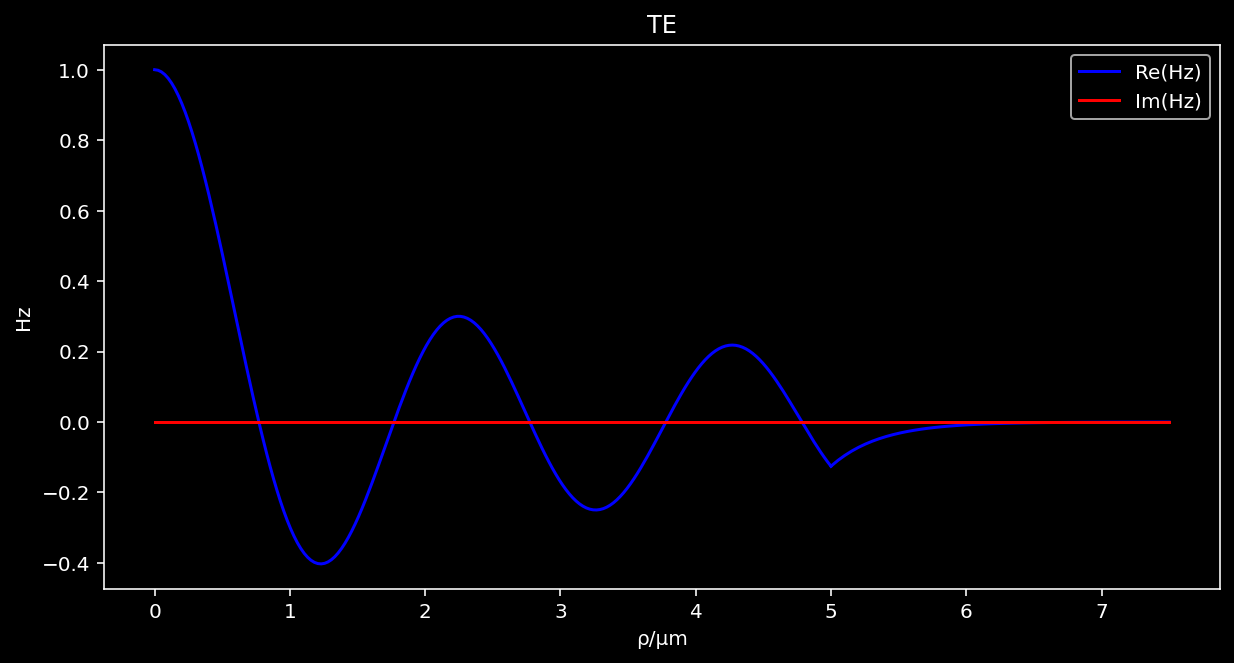

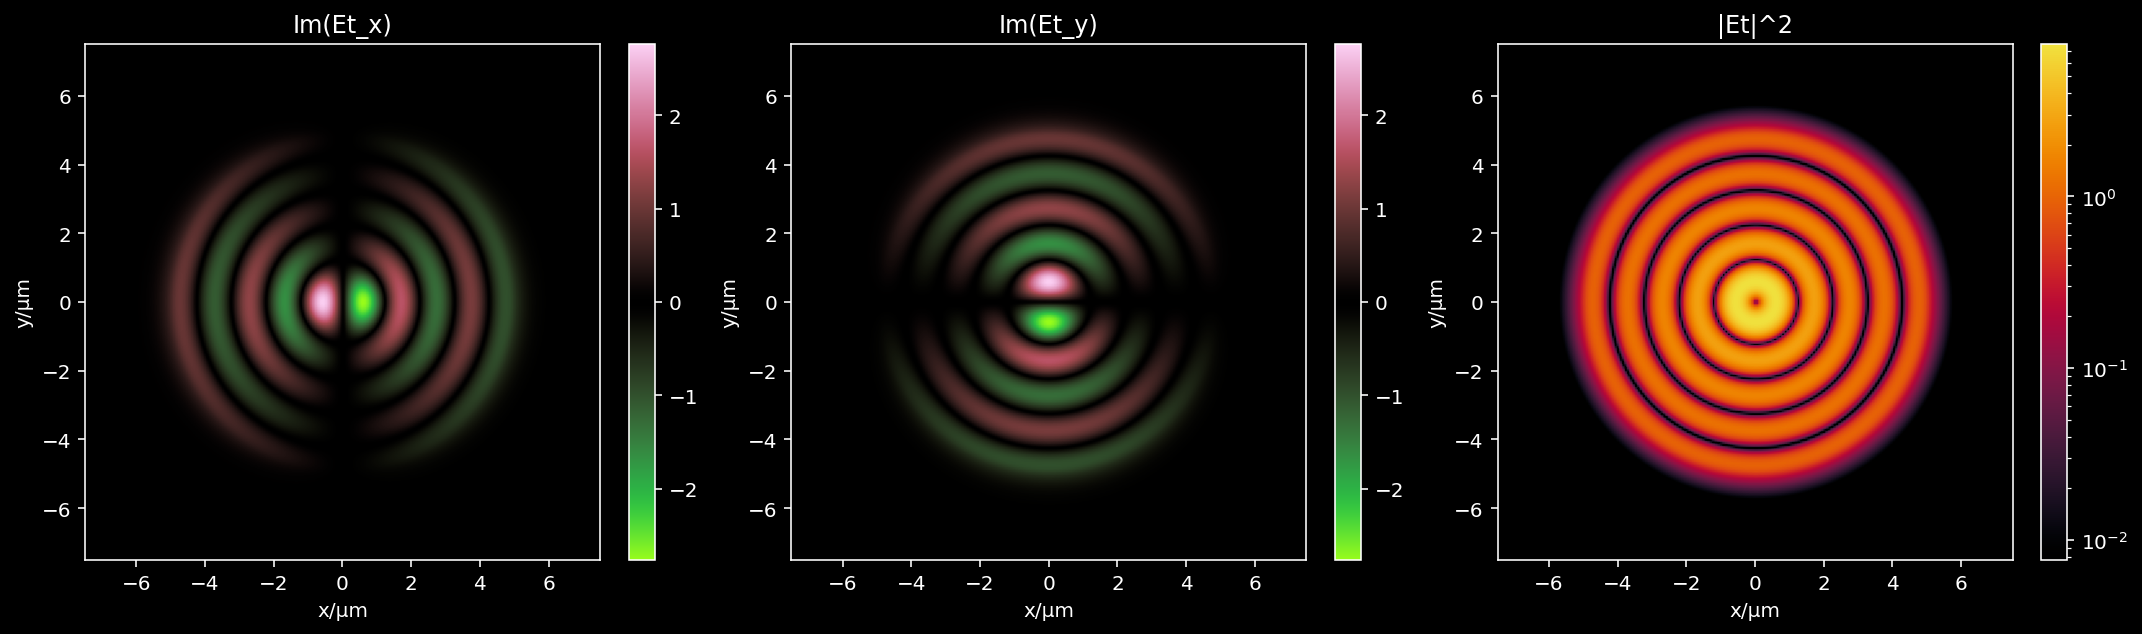

0 1 0 -193397.18468008417


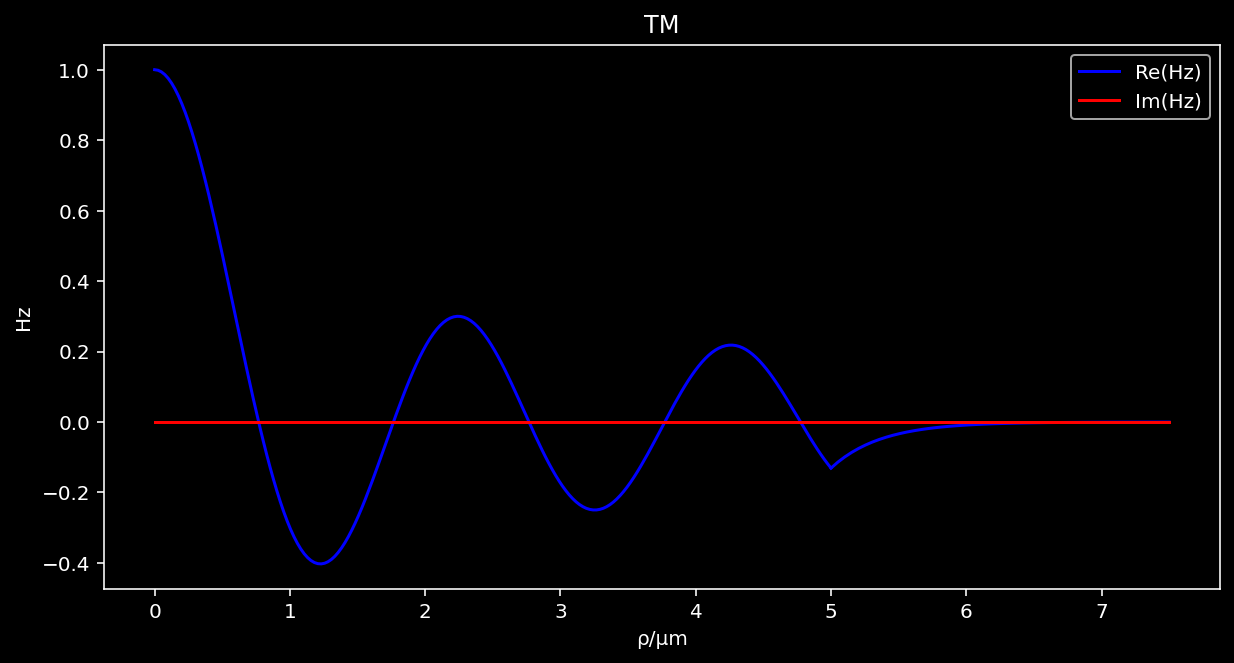

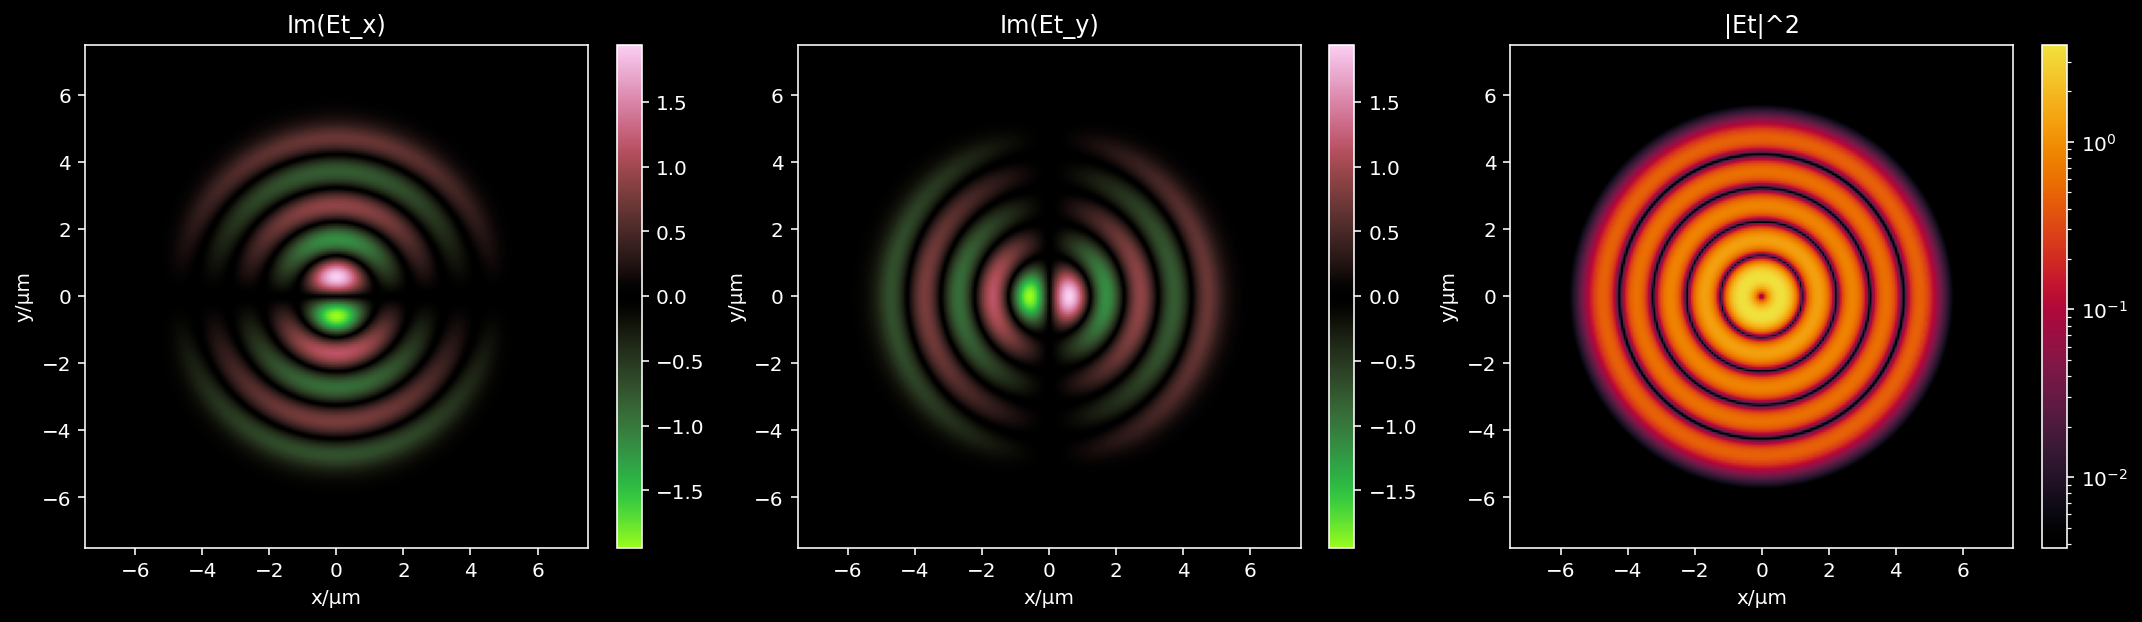

In [49]:
a = fiber_sol['coreRadius']
b = a*1.5 # assumed, in reality the cladding is assumed to be infinite
nCore = fiber_sol['nCore']
nCladding = fiber_sol['nCladding']

# given a value for plot the axial and transverse fields
m = 0
n = 2
λfree = fiber_sol['free_space_wavelength']

xrange = np.linspace(-b, b, 200)
yrange = np.linspace(-b, b, 200)
X, Y = np.meshgrid(xrange, yrange)

for modtype in ["TE","TM"]:
    Ae, Ah, Be, Bh = ws.AeAhBeBh(modtype, a, nCore, nCladding, λfree, m, kz)
    kz = fiber_sol['%skz' % modtype][m][n]
    γ = np.sqrt(nCore**2*4*np.pi**2/λfree**2 - kz**2)
    β = np.sqrt(kz**2 - nCladding**2*4*np.pi**2/λfree**2)
    print(Ae, Ah, Be, Bh)

    Ez_1 = ws.Ezgen_1(Ae, m, γ)
    Ez_2 = ws.Ezgen_2(Be, m, β)
    Hz_1 = ws.Hzgen_1(Ah, m, γ)
    Hz_2 = ws.Hzgen_2(Bh, m, β)

    Et1 = ws.Et1gen_1(Ae, Ah, Be, Bh, m, β, γ, kz, λfree)
    Et2 = ws.Et2gen_1(Ae, Ah, Be, Bh, m, β, γ, kz, λfree)
    Ht1 = ws.Ht1gen_1(Ae, Ah, Be, Bh, m, β, γ, kz, λfree, nCore)
    Ht2 = ws.Ht2gen_1(Ae, Ah, Be, Bh, m, β, γ, kz, λfree, nCladding)

    ρrangein = np.linspace(0, a, 200)
    ρrangeout = np.linspace(a, b, 50)

    Ezvals1 = Ez_1(ρrangein)
    Ezvals2 = Ez_2(ρrangeout)
    Hzvals1 = Hz_1(ρrangein)
    Hzvals2 = Hz_2(ρrangeout)

    fig, ax = plt.subplots(nrows=1,figsize=(10,5))
    if modtype == "TM":
        ax.plot(ρrangein, np.real(Hzvals1),'b', label='Re(Hz)')
        ax.plot(ρrangeout, np.real(Hzvals2),'b')
        ax.plot(ρrangein, np.imag(Hzvals1),'r', label='Im(Hz)')
        ax.plot(ρrangeout, np.imag(Hzvals2),'r')
    else:
        ax.plot(ρrangein, np.real(Ezvals1),'b', label='Re(Hz)')
        ax.plot(ρrangeout, np.real(Ezvals2),'b')
        ax.plot(ρrangein, np.imag(Ezvals1),'r', label='Im(Hz)')
        ax.plot(ρrangeout, np.imag(Ezvals2),'r')
    ax.set_xlabel('ρ/µm')
    ax.set_ylabel('Hz')
    ax.set_title(modtype)
    ax.legend()
    plt.subplots_adjust()
    plt.show()

    Etvals1 = Et1(X, Y)
    Etvals2 = Et2(X, Y)
    Htvals1 = Ht1(X, Y)
    Htvals2 = Ht2(X, Y)

    fieldarray1 = np.imag(Etvals1[0,:,])
    fieldarray1[X**2 + Y**2 > a**2] = 0
    fieldarray2 = np.imag(Etvals2[0,:,])
    fieldarray2[X**2 + Y**2 < a**2] = 0
    fieldarray_xim = fieldarray1 + fieldarray2

    fieldarray1 = np.imag(Etvals1[1,:,])
    fieldarray1[X**2 + Y**2 > a**2] = 0
    fieldarray2 = np.imag(Etvals2[1,:,])
    fieldarray2[X**2 + Y**2 < a**2] = 0
    fieldarray_yim = fieldarray1 + fieldarray2

    fieldarray1 = np.imag(Etvals1[0,:,])**2 + np.imag(Etvals1[1,:,])**2
    fieldarray1[X**2 + Y**2 > a**2] = 0
    fieldarray2 = np.imag(Etvals2[0,:,])**2 + np.imag(Etvals2[1,:,])**2
    fieldarray2[X**2 + Y**2 < a**2] = 0
    fieldarray_mag2 = fieldarray1 + fieldarray2

    plotfields = [fieldarray_xim, fieldarray_yim, fieldarray_mag2]

    labels = ['Im(Et_x)', 'Im(Et_y)', '|Et|^2']

    fig, axes = plt.subplots(nrows = 1, ncols=3, figsize=(15,5))

    for idx, (pfield, label) in enumerate(zip(plotfields, labels)):
        ax = axes[idx]
        if label == '|Et|^2':
            cmap = cm.ember
            maxmag2 = np.max(fieldarray_mag2)
            iplot = ax.imshow(fieldarray_mag2, 
                    norm=LogNorm(vmin=maxmag2*1e-3, vmax=maxmag2),
                    cmap=cmap, 
                    extent=[-a*1.5, a*1.5, -a*1.5, a*1.5])
        else:
            cmap = cm.watermelon
            iplot = ax.imshow(pfield, 
                cmap=cmap, 
                extent=[-a*1.5, a*1.5, -a*1.5, a*1.5])
        ax.set_title(label)
        ax.set_xlabel('x/µm')
        ax.set_ylabel('y/µm')
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.2)
        plt.colorbar(iplot, cax=cax)
    plt.tight_layout()
    plt.show()

In [50]:
# fieldarray1 = np.imag(Etvals1[0,:,])
# fieldarray1[X**2 + Y**2 > a**2] = 0
# fieldarray2 = np.imag(Etvals2[0,:,])
# fieldarray2[X**2 + Y**2 < a**2] = 0
# fieldarray_xim = fieldarray1 + fieldarray2

# fieldarray1 = np.imag(Etvals1[1,:,])
# fieldarray1[X**2 + Y**2 > a**2] = 0
# fieldarray2 = np.imag(Etvals2[1,:,])
# fieldarray2[X**2 + Y**2 < a**2] = 0
# fieldarray_yim = fieldarray1 + fieldarray2

# fieldarray1 = np.imag(Etvals1[0,:,])**2 + np.imag(Etvals1[1,:,])**2
# fieldarray1[X**2 + Y**2 > a**2] = 0
# fieldarray2 = np.imag(Etvals2[0,:,])**2 + np.imag(Etvals2[1,:,])**2
# fieldarray2[X**2 + Y**2 < a**2] = 0
# fieldarray_mag2 = fieldarray1 + fieldarray2

# plotfields = [fieldarray_xim, fieldarray_yim, fieldarray_mag2]

# labels = ['Im(Et_x)', 'Im(Et_y)', '|Et|^2']

# fig, axes = plt.subplots(nrows = 1, ncols=3, figsize=(15,5))

# for idx, (pfield, label) in enumerate(zip(plotfields, labels)):
#     ax = axes[idx]
#     if label == '|Et|^2':
#         cmap = cm.ember
#         maxmag2 = np.max(fieldarray_mag2)
#         iplot = ax.imshow(fieldarray_mag2, 
#                 norm=LogNorm(vmin=maxmag2*1e-3, vmax=maxmag2),
#                 cmap=cmap, 
#                 extent=[-a*1.5, a*1.5, -a*1.5, a*1.5])
#     else:
#         cmap = cm.watermelon
#         iplot = ax.imshow(pfield, 
#             cmap=cmap, 
#             extent=[-a*1.5, a*1.5, -a*1.5, a*1.5])
#     ax.set_title(label)
#     ax.set_xlabel('x/µm')
#     ax.set_ylabel('y/µm')
#     divider = make_axes_locatable(ax)
#     cax = divider.append_axes("right", size="5%", pad=0.2)
#     plt.colorbar(iplot, cax=cax)
# plt.tight_layout()
# plt.show()

In [51]:
# Ex1 = np.imag(Etvals1[0,:,:])
# Ex1[X**2 + Y**2 > a**2] = 0
# Ex2 = np.imag(Etvals2[0,:,:])
# Ex2[X**2 + Y**2 < a**2] = 0
# Ex = Ex1 + Ex2
# Ey1 = np.imag(Etvals1[1,:,:])
# Ey1[X**2 + Y**2 > a**2] = 0
# Ey2 = np.imag(Etvals2[1,:,:])
# Ey2[X**2 + Y**2 < a**2] = 0
# Ey = Ey1 + Ey2

# Hx1 = np.imag(Htvals1[0,:,:])
# Hx1[X**2 + Y**2 > a**2] = 0
# Hx2 = np.imag(Htvals2[0,:,:])
# Hx2[X**2 + Y**2 < a**2] = 0
# Hx = Hx1 + Hx2
# Hy1 = np.imag(Htvals1[1,:,:])
# Hy1[X**2 + Y**2 > a**2] = 0
# Hy2 = np.imag(Htvals2[1,:,:])
# Hy2[X**2 + Y**2 < a**2] = 0
# Hy = Hy1 + Hy2

# fig, axes = plt.subplots(ncols=2, figsize=(10,5))
# axes[0].streamplot(xrange, yrange, Ex, Ey, arrowstyle='-', density=2)
# axes[0].set_xlabel('x/µm')
# axes[0].set_ylabel('y/µm')
# axes[0].set_title('E')
# axes[0].set_aspect('equal')

# axes[1].streamplot(xrange, yrange, Hx, Hy, arrowstyle='-', density=2)
# axes[1].set_xlabel('x/µm')
# axes[1].set_ylabel('y/µm')
# axes[1].set_title('H')
# axes[1].set_aspect('equal')
# plt.show()

In [52]:
# Ae, Ah, Be, Bh = ws.AeAhBeBh("TE", a, nCore, nCladding, λfree, m, kz)

# print(Ae, Ah, Be, Bh)

# Ez_1 = ws.Ezgen_1(Ae, m, γ)
# Ez_2 = ws.Ezgen_2(Be, m, β)
# Hz_1 = ws.Hzgen_1(Ah, m, γ)
# Hz_2 = ws.Hzgen_2(Bh, m, β)

# Et1 = ws.Et1gen_1(Ae, Ah, Be, Bh, m, β, γ, kz, λfree)
# Et2 = ws.Et2gen_1(Ae, Ah, Be, Bh, m, β, γ, kz, λfree)
# Ht1 = ws.Ht1gen_1(Ae, Ah, Be, Bh, m, β, γ, kz, λfree, nCore)
# Ht2 = ws.Ht2gen_1(Ae, Ah, Be, Bh, m, β, γ, kz, λfree, nCladding)

# ρrangein = np.linspace(0, a, 200)
# ρrangeout = np.linspace(a, b, 50)

# Ezvals1 = Ez_1(ρrangein)
# Ezvals2 = Ez_2(ρrangeout)
# Hzvals1 = Hz_1(ρrangein)
# Hzvals2 = Hz_2(ρrangeout)

# fig, ax = plt.subplots(nrows=1,figsize=(10,5))
# ax.plot(ρrangein, np.real(Ezvals1),'b', label='Re(Ez)')
# ax.plot(ρrangeout, np.real(Ezvals2),'b')
# ax.plot(ρrangein, np.imag(Ezvals1),'r', label='Im(Ez)')
# ax.plot(ρrangeout, np.imag(Ezvals2),'r')
# ax.set_xlabel('ρ/µm')
# ax.set_ylabel('Hz')
# ax.legend()
# plt.subplots_adjust()
# plt.show()

In [53]:
# fieldarray1 = np.imag(Etvals1[0,:,])
# fieldarray1[X**2 + Y**2 > a**2] = 0
# fieldarray2 = np.imag(Etvals2[0,:,])
# fieldarray2[X**2 + Y**2 < a**2] = 0
# fieldarray_xim = fieldarray1 + fieldarray2

# fieldarray1 = np.imag(Etvals1[1,:,])
# fieldarray1[X**2 + Y**2 > a**2] = 0
# fieldarray2 = np.imag(Etvals2[1,:,])
# fieldarray2[X**2 + Y**2 < a**2] = 0
# fieldarray_yim = fieldarray1 + fieldarray2

# fieldarray1 = np.imag(Etvals1[0,:,])**2 + np.imag(Etvals1[1,:,])**2
# fieldarray1[X**2 + Y**2 > a**2] = 0
# fieldarray2 = np.imag(Etvals2[0,:,])**2 + np.imag(Etvals2[1,:,])**2
# fieldarray2[X**2 + Y**2 < a**2] = 0
# fieldarray_mag2 = fieldarray1 + fieldarray2

# plotfields = [fieldarray_xim, fieldarray_yim, fieldarray_mag2]

# labels = ['Im(Et_x)', 'Im(Et_y)', '|Et|^2']

# fig, axes = plt.subplots(nrows = 1, ncols=3, figsize=(15,5))

# for idx, (pfield, label) in enumerate(zip(plotfields, labels)):
#     ax = axes[idx]
#     if label == '|Et|^2':
#         cmap = cm.ember
#         maxmag2 = np.max(fieldarray_mag2)
#         iplot = ax.imshow(fieldarray_mag2, 
#                 norm=LogNorm(vmin=maxmag2*1e-3, vmax=maxmag2),
#                 cmap=cmap, 
#                 extent=[-a*1.5, a*1.5, -a*1.5, a*1.5])
#     else:
#         cmap = cm.watermelon
#         iplot = ax.imshow(pfield, 
#             cmap=cmap, 
#             extent=[-a*1.5, a*1.5, -a*1.5, a*1.5])
#     ax.set_title(label)
#     ax.set_xlabel('x/µm')
#     ax.set_ylabel('y/µm')
#     divider = make_axes_locatable(ax)
#     cax = divider.append_axes("right", size="5%", pad=0.2)
#     plt.colorbar(iplot, cax=cax)
# plt.tight_layout()
# plt.show()

### ###Calculating the eigenbasis

In [7]:
# given a spatial resolution r, calculate an array
# that contains the necessary data to decompose a 
# a given field into a sum of modes.
# I will do this in a cartesian coordinate system
# although probably doing this in cylindrical coordinates
# would be more efficient

a = fiber_sol['coreRadius']
b = a*1.5 # assumed, in reality the cladding is assumed to be infinite
nCore = fiber_sol['nCore']
nCladding = fiber_sol['nCladding']
λfree = fiber_sol['free_space_wavelength']

resolution = λfree / nCore / 2
# calculate the coordinates arrays
numSamples = int(2 * b / resolution)
xrange = np.linspace(-b, b, numSamples)
yrange = np.linspace(-b, b, numSamples)
Xg, Yg = np.meshgrid(xrange, yrange)

# determine how many modes there are in total
totalModes = sum(list(map(len,fiber_sol['HEkz'].values())))
totalModes += len(fiber_sol['TMkz'][0])
totalModes += len(fiber_sol['TEkz'][0])


eigenbasis = np.zeros((totalModes, 2, 2, numSamples, numSamples), dtype=np.complex64)
counter = 0
inner_mask = (Xg**2 + Yg**2 <= a**2)
outer_mask = (Xg**2 + Yg**2 > a**2)
annotations = []

for modtype in ['TE','TM','HE']:
    solkey = modtype + 'kz'
    for m, kzs in fiber_sol[solkey].items():
        for kzidx, kz in enumerate(tqdm(kzs)):
            γ = np.sqrt(nCore**2*4*np.pi**2/λfree**2 - kz**2)
            β = np.sqrt(kz**2 - nCladding**2*4*np.pi**2/λfree**2)

            Ae, Ah, Be, Bh = ws.AeAhBeBh(modtype, a, nCore, nCladding, λfree, m, kz)
            Et1 = ws.Et1gen_1(Ae, Ah, Be, Bh, m, β, γ, kz, λfree)
            Et2 = ws.Et2gen_1(Ae, Ah, Be, Bh, m, β, γ, kz, λfree)
            Ht1 = ws.Ht1gen_1(Ae, Ah, Be, Bh, m, β, γ, kz, λfree, nCore)
            Ht2 = ws.Ht2gen_1(Ae, Ah, Be, Bh, m, β, γ, kz, λfree, nCladding)
            Etvals1 = Et1(Xg, Yg)
            Etvals1[0,outer_mask] = 0
            Etvals1[1,outer_mask] = 0
            Etvals2 = Et2(Xg, Yg)
            Etvals2[0,inner_mask] = 0
            Etvals2[1,inner_mask] = 0
            Et = Etvals1 + Etvals2
            Et[np.isnan(Et)] = 0
            Etnorm = np.sum(np.abs(Et[0,::])**2 + np.abs(Et[1,::])**2)
            Etnorm = np.sqrt(Etnorm)
            Et /= Etnorm
            Htvals1 = Ht1(Xg, Yg)
            Htvals1[0,outer_mask] = 0
            Htvals1[1,outer_mask] = 0
            Htvals2 = Ht2(Xg, Yg)
            Htvals2[0,inner_mask] = 0
            Htvals2[1,inner_mask] = 0
            Ht = Htvals1 + Htvals2
            Ht[np.isnan(Ht)] = 0
            Htnorm = np.sum(np.abs(Ht[0,::])**2 + np.abs(Ht[1,::])**2)
            Htnorm = np.sqrt(Htnorm)
            Ht /= Htnorm
            eigenbasis[counter, 0, :, :, :] = Et
            eigenbasis[counter, 1, :, :, :] = Ht
            counter += 1
            annotationTR = '%s(%d,%d)' % (modtype, m, kzidx)
            annotationBR = 'kz=%.1f µm⁻¹' % (kz)
            annotations.append((annotationTR, annotationBR))


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

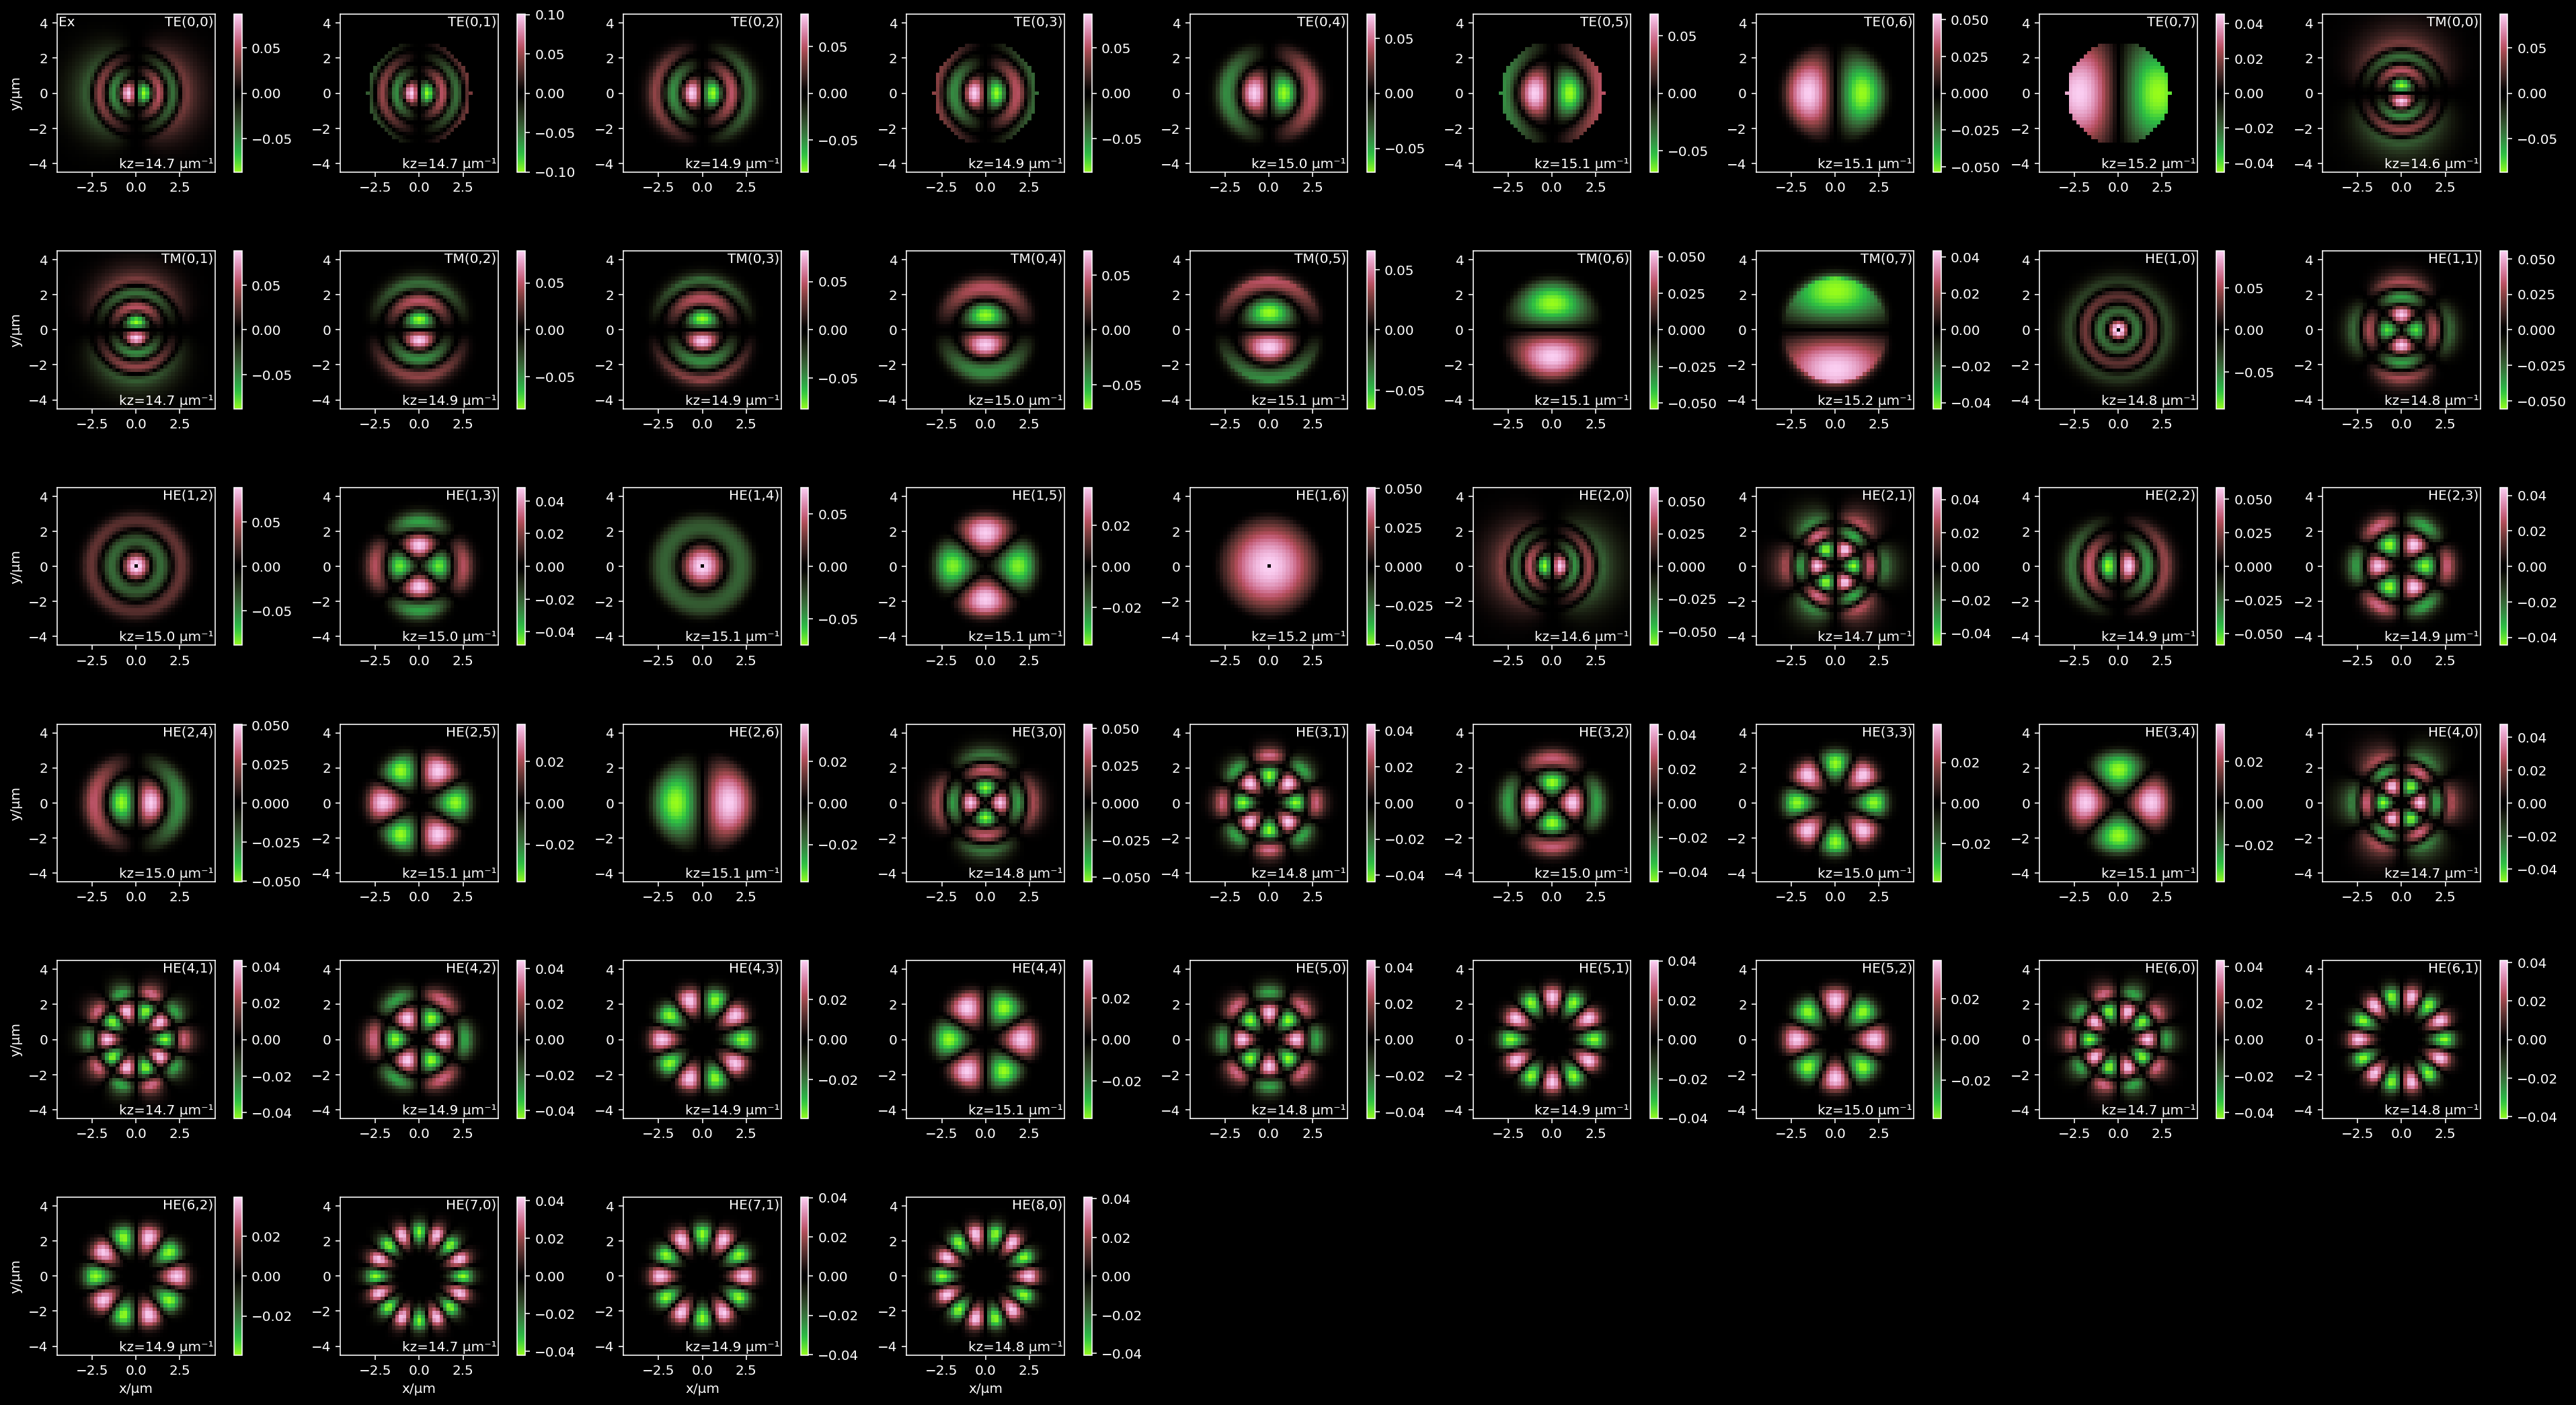

In [8]:
aratio = 16/9
nrows, ncols = ws.find_layout_rectangle(aratio, totalModes)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15*aratio,15))
counter = 0
plotkind = 'Ex'
# plotkind = '|E|^2'
cmap = {'Ex': cm.watermelon, '|E|^2': cm.ember}[plotkind]
for rowidx in range(nrows):
    for colidx in range(ncols):
        print(rowidx, colidx, end='\r')
        idx = rowidx * ncols + colidx
        axis = axes[rowidx, colidx]
        if idx >= totalModes - 1:
            axes[rowidx, colidx].set_axis_off()
            continue
        if plotkind == 'Ex':
            plotfield = np.imag(eigenbasis[idx,0,0,:,:])
            pfmax = np.max(plotfield)
            pfmin = np.min(plotfield)
            pfrange = max(pfmax, np.abs(pfmin))
            vmax = pfrange
            vmin = -pfrange
        elif plotkind == '|E|^2':
            plotfield = np.abs(eigenbasis[idx,0,0,:,:])**2 + np.abs(eigenbasis[idx,0,1,:,:])**2
            pfmax = np.max(plotfield)
            vmax = pfmax
            vmin = 0
        iplot = axis.imshow(plotfield,
                    extent=[-b, b, -b, b],
                    origin='lower',
                    vmin=vmin, 
                    vmax=vmax,
                    cmap=cmap)
        axis.text(0.99, 0.99, annotations[counter][0], transform=axis.transAxes, horizontalalignment='right', verticalalignment='top')
        axis.text(0.99, 0.01, annotations[counter][1], transform=axis.transAxes, horizontalalignment='right', verticalalignment='bottom')
        if rowidx == 0 and colidx == 0:
            axis.text(0.01, 0.99, plotkind, transform=axis.transAxes, horizontalalignment='left', verticalalignment='top')
        divider = make_axes_locatable(axis)
        cax = divider.append_axes("right", size="5%", pad=0.2)
        plt.colorbar(iplot, cax=cax)
        if colidx == 0:
            axes[rowidx, colidx].set_ylabel('y/µm')
        if rowidx == nrows - 1:
            axes[rowidx, colidx].set_xlabel('x/µm')
        counter += 1
plt.tight_layout()
plt.show()

## ##Gray Notation (deprecated)

/Users/juan/ZiaLab/Codebase/wavesight/wavesight.py:19: RuntimeWarning: invalid value encountered in sqrt
  return  (n1**2*(special.jv(-1 + n,a*np.sqrt(-γ**2 + (4*n1**2*np.pi**2)/λfree**2)) - special.jv(1 + n,a*np.sqrt(-γ**2 + (4*n1**2*np.pi**2)/λfree**2))))/(2.*a*n0**2*np.sqrt(-γ**2 + (4*n1**2*np.pi**2)/λfree**2)*special.jv(n,a*np.sqrt(-γ**2 + (4*n1**2*np.pi**2)/λfree**2))) + (-special.kn(-1 + n,a*np.sqrt(γ**2 - (4*n0**2*np.pi**2)/λfree**2)) - special.kn(1 + n,a*np.sqrt(γ**2 - (4*n0**2*np.pi**2)/λfree**2)))/(2.*a*np.sqrt(γ**2 - (4*n0**2*np.pi**2)/λfree**2)*special.kn(n,a*np.sqrt(γ**2 - (4*n0**2*np.pi**2)/λfree**2)))


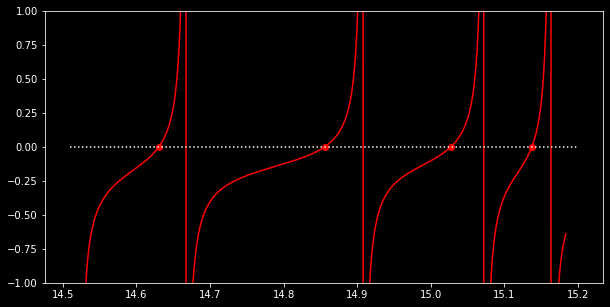

In [ ]:
nCore = 1.45
nCladding = 1.387
coreRadius = 3.
wavelength = 0.6
tmfun = ws.tmfungen(λfree=wavelength, 
                 n=0, 
                 n0=nCladding, 
                 n1=nCore, 
                 a=coreRadius)
γmax = 1.001*nCore*2*np.pi/wavelength
γmin = 0.999*nCladding*2*np.pi/wavelength
γrange = np.linspace(γmin, γmax, 1000)
tmvals = tmfun(γrange)
tmzeros = ws.findallroots(tmfun, γmin, γmax, 0.01, method='bisect', num_decimals=6, verbose=False)
tmzerocheck = tmfun(tmzeros)
plt.figure(figsize=(10,5))
plt.plot(γrange, tmvals, 'r')
plt.scatter(tmzeros,tmzerocheck, c='r')
plt.plot([γmin, γmax], [0,0], "w:")
plt.ylim(-1,1)
plt.show()

/Users/juan/ZiaLab/Codebase/wavesight/wavesight.py:25: RuntimeWarning: invalid value encountered in sqrt
  return (special.jv(-1 + n,a*np.sqrt(-γ**2 + (4*n1**2*np.pi**2)/λfree**2)) - special.jv(1 + n,a*np.sqrt(-γ**2 + (4*n1**2*np.pi**2)/λfree**2)))/(2.*a*np.sqrt(-γ**2 + (4*n1**2*np.pi**2)/λfree**2)*special.jv(n,a*np.sqrt(-γ**2 + (4*n1**2*np.pi**2)/λfree**2))) + (-special.kn(-1 + n,a*np.sqrt(γ**2 - (4*n0**2*np.pi**2)/λfree**2)) - special.kn(1 + n,a*np.sqrt(γ**2 - (4*n0**2*np.pi**2)/λfree**2)))/(2.*a*np.sqrt(γ**2 - (4*n0**2*np.pi**2)/λfree**2)*special.kn(n,a*np.sqrt(γ**2 - (4*n0**2*np.pi**2)/λfree**2)))


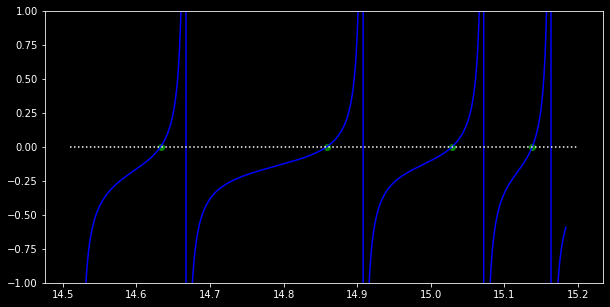

In [ ]:
nCore = 1.45
nCladding = 1.387
coreRadius = 3.
wavelength = 0.6
tefun = ws.tefungen(λfree=wavelength, 
                 n=0, 
                 n0=nCladding, 
                 n1=nCore, 
                 a=coreRadius)
γmax = 1.001*nCore*2*np.pi/wavelength
γmin = 0.999*nCladding*2*np.pi/wavelength
γrange = np.linspace(γmin, γmax, 1000)
tevals = tefun(γrange)
tezeros = ws.findallroots(tefun, γmin, γmax, 0.01, method='bisect', num_decimals=6)
tezerocheck = tefun(tezeros)
plt.figure(figsize=(10,5))
plt.plot(γrange, tevals, 'b')
plt.scatter(tezeros,tezerocheck, c='g')
plt.plot([γmin, γmax], [0,0], "w:")
plt.ylim(-1,1)
plt.show()

/Users/juan/ZiaLab/Codebase/wavesight/wavesight.py:30: RuntimeWarning: invalid value encountered in sqrt
  return  -((n**2*(1/(γ**2 - (4*n0**2*np.pi**2)/λfree**2) + 1/(-γ**2 + (4*n1**2*np.pi**2)/λfree**2))*(1/(a**2*(γ**2 - (4*n0**2*np.pi**2)/λfree**2)) + n1**2/(a**2*n0**2*(-γ**2 + (4*n1**2*np.pi**2)/λfree**2))))/a**2) + ((special.jv(-1 + n,a*np.sqrt(-γ**2 + (4*n1**2*np.pi**2)/λfree**2)) - special.jv(1 + n,a*np.sqrt(-γ**2 + (4*n1**2*np.pi**2)/λfree**2)))/(2.*a*np.sqrt(-γ**2 + (4*n1**2*np.pi**2)/λfree**2)*special.jv(n,a*np.sqrt(-γ**2 + (4*n1**2*np.pi**2)/λfree**2))) + (-special.kn(-1 + n,a*np.sqrt(γ**2 - (4*n0**2*np.pi**2)/λfree**2)) - special.kn(1 + n,a*np.sqrt(γ**2 - (4*n0**2*np.pi**2)/λfree**2)))/(2.*a*np.sqrt(γ**2 - (4*n0**2*np.pi**2)/λfree**2)*special.kn(n,a*np.sqrt(γ**2 - (4*n0**2*np.pi**2)/λfree**2))))*((n1**2*(special.jv(-1 + n,a*np.sqrt(-γ**2 + (4*n1**2*np.pi**2)/λfree**2)) - special.jv(1 + n,a*np.sqrt(-γ**2 + (4*n1**2*np.pi**2)/λfree**2))))/(2.*a*n0**2*np.sqrt(-γ**2 + (4*n1**2*

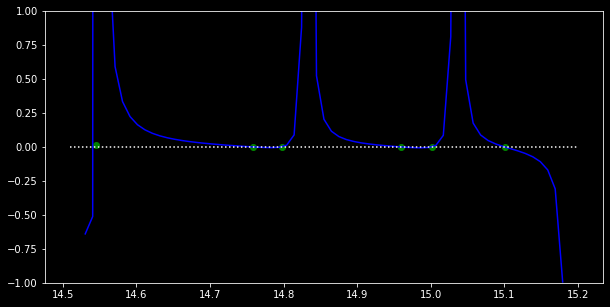

In [ ]:
nCore = 1.45
nCladding = 1.387
coreRadius = 3.
wavelength = 0.6
n=3
hefun = ws.hefungen(λfree=wavelength, 
                 n=n, 
                 n0=nCladding, 
                 n1=nCore, 
                 a=coreRadius)
γmax = 1.001*nCore*2*np.pi/wavelength
γmin = 0.999*nCladding*2*np.pi/wavelength
# γrange = np.linspace(γmin, γmax, 1000)
dx = 0.01
γrange = np.linspace(γmin, γmax, int(np.ceil((γmax-γmin)/dx)))
hevals = hefun(γrange)
zc = ws.zerocrossings(hevals)
zcvals = hevals[zc]
good_crossings = np.where(~np.isnan(zcvals))
zcvals = zcvals[good_crossings]
zc = zc[good_crossings]
hezeros = ws.findallroots(hefun, γmin, γmax, dx, method='bisect', num_decimals=6, verbose=False)
hezerocheck = hefun(hezeros)
plt.figure(figsize=(10,5))
plt.plot(γrange, hevals, 'b')
plt.scatter(hezeros,hezerocheck, c='g')
plt.plot([γmin, γmax], [0,0], "w:")
plt.ylim(-1,1)
plt.show()